## 1. 데이터
---
- augmentation 기법(의료영상은 신중해야함)

### 데이터 가져오기

In [29]:
import re
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOT_PATH = os.path.join(os.getenv('HOME'), 'project/aiffel/e/e22')
BATCH_SIZE = 16
IMAGE_SIZE = [180, 180]
EPOCHS = 25

In [30]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/data/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/data/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/data/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [31]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/data/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/data/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [32]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

print('Normal images in training set: ', str(COUNT_NORMAL))
print('PNEUMONIOA images in training set: ', str(COUNT_PNEUMONIA))

Normal images in training set:  1058
PNEUMONIOA images in training set:  3127


### 이미지 리사이즈와 라벨링

In [33]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [34]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [35]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/data/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [36]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [37]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [38]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [39]:
for image, label in train_ds.take(1):
    print('image shape: ', image.numpy().shape)
    print('label: ', label.numpy())

image shape:  (180, 180, 3)
label:  True


In [40]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/data/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 학습 데이터 처리 및 시각화

In [41]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [14]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [15]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

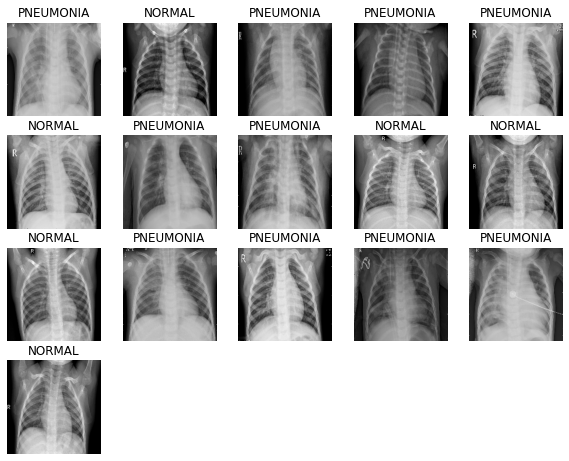

In [16]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')
        
show_batch(image_batch.numpy(), label_batch.numpy())

### 데이터 불균형 처리

In [17]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for 0: {:.2f}'.format(weight_for_0))
print('Weight for 1: {:.2f}'.format(weight_for_1))

Weight for 0: 1.96
Weight for 1: 0.67


## 2. CNN 모델링
---
- BatchNormalization, Dropout의 적용 여부

### Conv block

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

### Dense block

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

### Build Model

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 3. 모델 훈련
---
- optimizer, learning rate 등의 변화

In [20]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 93ms/step - loss: 0.4113 - accuracy: 0.7938 - precision: 0.9462 - recall: 0.7658 - val_loss: 0.5792 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 93ms/step - loss: 0.2361 - accuracy: 0.8977 - precision: 0.9715 - recall: 0.8886 - val_loss: 0.7954 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1960 - accuracy: 0.9231 - precision: 0.9793 - recall: 0.9158 - val_loss: 1.0095 - val_accuracy: 0.5538 - val_precision: 1.0000 - val_recall: 0.3974
Epoch 4/25
261/261 [==============================] - 23s 89ms/step - loss: 0.1832 - accuracy: 0.9339 - precision: 0.9780 - recall: 0.9320 - val_loss: 0.1912 - val_accuracy: 0.9096 - val_precision: 0.8917 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1581 - accuracy: 0

## 4. 결과 확인 및 개선
---
- accuracy와 recall 고려

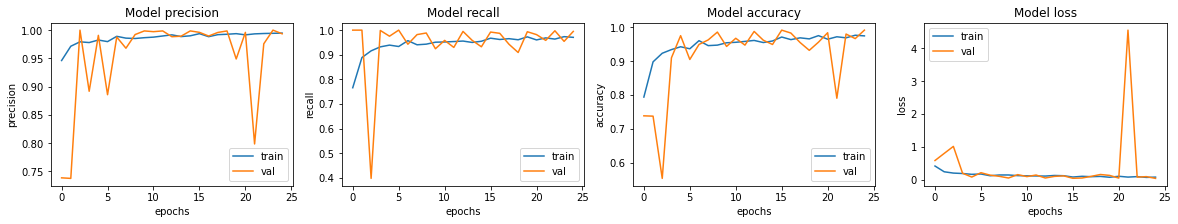

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+ met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 1.3485 - accuracy: 0.7644 - precision: 0.7280 - recall: 0.9949


### Dropout 제거
- 성능 개선을 위해 dropout을 제거해보았다

In [23]:
def build_model_no_drop():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0),
        dense_block(128, 0),
        dense_block(64, 0),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [24]:
with tf.device('/GPU:0'):
    model_no_drop = build_model_no_drop()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_drop.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history_no_drop = model_no_drop.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 91ms/step - loss: 0.2338 - accuracy: 0.9088 - precision: 0.9745 - recall: 0.9007 - val_loss: 0.6313 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1550 - accuracy: 0.9420 - precision: 0.9808 - recall: 0.9403 - val_loss: 0.7992 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1189 - accuracy: 0.9574 - precision: 0.9880 - recall: 0.9543 - val_loss: 0.1475 - val_accuracy: 0.9548 - val_precision: 0.9478 - val_recall: 0.9935
Epoch 4/25
261/261 [==============================] - 24s 92ms/step - loss: 0.1163 - accuracy: 0.9555 - precision: 0.9873 - recall: 0.9522 - val_loss: 0.0758 - val_accuracy: 0.9731 - val_precision: 0.9920 - val_recall: 0.9714
Epoch 5/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1047 - accuracy: 0

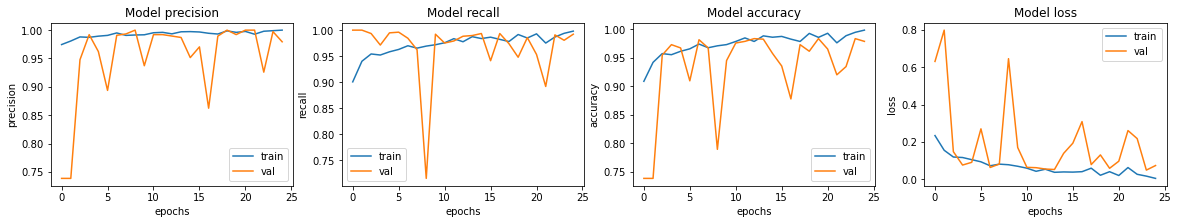

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_drop.history[met])
    ax[i].plot(history_no_drop.history['val_'+ met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, acc, prec, rec = model_no_drop.evaluate(test_ds)

39/39 [==============================] - 2s 55ms/step - loss: 1.7750 - accuracy: 0.7324 - precision: 0.7024 - recall: 0.9923


### Augmentation 추가
- 성능이 오히려 떨어져 데이터에 augmentation을 추가하고 batch_size를 늘려보았다
- augmentation은 좌우반전만 적용하였다

In [25]:
BATCH_SIZE = 32

In [42]:
train_ds

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

In [43]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,
        num_parallel_calls=2
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

train_ds_aug = prepare_for_training(train_ds)
val_ds_aug = prepare_for_training(val_ds)

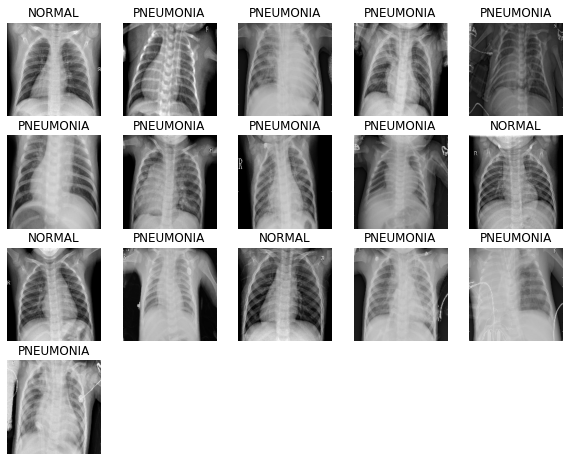

In [44]:
image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
        
show_batch(image_batch_aug.numpy(), label_batch_aug.numpy())

In [45]:
with tf.device('/GPU:0'):
    history_no_drop = model_no_drop.fit(
        train_ds_aug,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_aug,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 92ms/step - loss: 0.2416 - accuracy: 0.9037 - precision: 0.9715 - recall: 0.8974 - val_loss: 0.7149 - val_accuracy: 0.7221 - val_precision: 0.7221 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1723 - accuracy: 0.9332 - precision: 0.9766 - recall: 0.9331 - val_loss: 1.1837 - val_accuracy: 0.7221 - val_precision: 0.7221 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1605 - accuracy: 0.9368 - precision: 0.9807 - recall: 0.9334 - val_loss: 0.6427 - val_accuracy: 0.7779 - val_precision: 1.0000 - val_recall: 0.6920
Epoch 4/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1394 - accuracy: 0.9497 - precision: 0.9844 - recall: 0.9479 - val_loss: 0.3347 - val_accuracy: 0.8779 - val_precision: 0.9984 - val_recall: 0.8327
Epoch 5/25
261/261 [==============================] - 24s 91ms/step - loss: 0.1241 - accuracy: 0

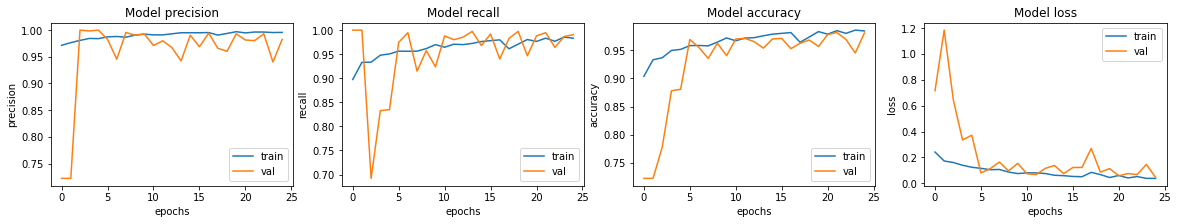

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_drop.history[met])
    ax[i].plot(history_no_drop.history['val_'+ met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [47]:
loss, acc, prec, rec = model_no_drop.evaluate(test_ds)

39/39 [==============================] - 2s 58ms/step - loss: 1.4433 - accuracy: 0.7548 - precision: 0.7207 - recall: 0.9923


### Report

In [ ]:
- 여러가지 방법을 써보았지만 베이스 모델보다 높은 정확도를 얻지 못했다